In [1]:
#@title 🔧 Install and Import Required Libraries
%%capture
# Install all required libraries
#!pip install -q transformers torch sentencepiece ipywidgets
#!pip uninstall -y gensim
#!pip install --upgrade --force-reinstall gensim
#!pip install numpy==1.26.4
#!pip install gensim
#!pip install -q pymupdf
#!pip install nltk
#!pip install --no-cache-dir spacy cython
#!pip install kneed
#!pip install numpy==1.26.4 --force-reinstall --no-cache-dir

# Import libraires
from huggingface_hub import login
import os, io, logging, requests
import fitz  # PyMuPDF
import nltk
from sklearn.metrics import calinski_harabasz_score
import contextlib
from itertools import combinations
import kagglehub
from bs4 import BeautifulSoup
from IPython.display import display, clear_output
import ipywidgets as widgets
from nltk.tokenize import sent_tokenize
import re
import string
import spacy
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download("vader_lexicon")
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from kneed import KneeLocator
from collections import Counter
from collections import defaultdict, Counter
from sklearn.metrics.pairwise import cosine_similarity
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
# from sentence_transformers import SentenceTransformer

In [2]:
#@title 🔧 Upload Data

# ─── Setup ─────────────────────────────────────────────────────────────────────
# Base directories & logging
base_dir = '/content/NLP_Thematic_Tool'
raw_dir  = os.path.join(base_dir, 'raw_data')
os.makedirs(raw_dir, exist_ok=True)

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)s %(message)s",
    handlers=[logging.FileHandler(os.path.join(base_dir, 'system.log')),
              logging.StreamHandler()]
)


# ─── Widgets ────────────────────────────────────────────────────────────────────
pdf_upload = widgets.FileUpload(
    accept='.pdf', multiple=True, description="Upload PDFs"
)
url_input = widgets.Textarea(
    placeholder='One URL per line', description='Web URLs:', layout=widgets.Layout(width='100%', height='100px')
)
process_btn = widgets.Button(description="Process Files", button_style='success')
output_box  = widgets.Output()

display(widgets.VBox([
    widgets.HTML("<h3>Step 1: Upload PDFs and/or enter URLs</h3>"),
    pdf_upload,
    url_input,
    process_btn,
    output_box
]))

# ─── Extraction Functions ──────────────────────────────────────────────────────
def extract_text_from_urls(lines):
    texts = []
    for idx, url in enumerate(lines, 1):
        try:
            resp = requests.get(url, timeout=10)
            soup = BeautifulSoup(resp.content, 'html.parser')
            txt  = soup.get_text(separator=' ', strip=True)
            texts.append(txt)
            logging.info(f"Scraped URL #{idx}: {url}")
        except Exception as e:
            logging.error(f"Error scraping {url}: {e}")
    return texts


def extract_text_from_pdfs(uploaded, batch_size=4):
    texts = []
    items = list(uploaded.items())

    for i in range(0, len(items), batch_size):
        batch = items[i:i + batch_size]
        print(f"📄 Processing batch {i // batch_size + 1} of {((len(items) - 1) // batch_size) + 1}...")

        for fname, info in batch:
            try:
                stream = io.BytesIO(info['content'])
                doc = fitz.open(stream=stream, filetype='pdf')
                text = " ".join(page.get_text() for page in doc)
                texts.append(text)
                logging.info(f"Extracted text from PDF: {fname}")
            except Exception as e:
                logging.error(f"Error processing {fname}: {e}")
                texts.append("")  # Append empty string to maintain alignment

    return texts


# ─── Button Callback ──────────────────────────────────────────────────────────
def on_process_clicked(btn):
    with output_box:
        clear_output()
        # 1. Gather PDF texts
        pdf_texts = extract_text_from_pdfs(pdf_upload.value)
        print(f"✔ PDFs processed: {len(pdf_texts)}")

        # 2. Gather URL texts (one per line)
        urls = [u.strip() for u in url_input.value.splitlines() if u.strip()]
        url_texts = extract_text_from_urls(urls)
        print(f"✔ URLs scraped:   {len(url_texts)}")

        # 3. Combine
        all_texts = pdf_texts + url_texts
        print(f"Total sources:    {len(all_texts)}\n")

        # Sanity check first 200 chars
        for i, doc in enumerate(all_texts, 1):
            print(f"--- Source #{i} preview ---")
            print(doc[:200].replace('\n',' ') + '...\n')

process_btn.on_click(on_process_clicked)

✔ PDFs processed: 0
✔ URLs scraped:   23
Total sources:    23

--- Source #1 preview ---
Applications of artificial intelligence in engineering and manufacturing: a systematic review | Journal of Intelligent Manufacturing Skip to main content Advertisement Log in Menu Find a journal Publi...

--- Source #2 preview ---
Applications of AI in classical software engineering | AI Perspectives & Advances Skip to main content Advertisement Log in Menu Find a journal Publish with us Track your research Search Cart Home AI ...

--- Source #3 preview ---
Challenges and Opportunities of AI-Enabled Monitoring, Diagnosis & Prognosis: A Review | Chinese Journal of Mechanical Engineering Skip to main content Advertisement Log in Menu Find a journal Publish...

--- Source #4 preview ---
AI: the future of humanity | Discover Artificial Intelligence Skip to main content Advertisement Log in Menu Find a journal Publish with us Track your research Search Cart Home Discover Artificial Int...

--- Source #5

In [3]:
#@title 🔧 Add Stopwords

# Extract all text
pdf_texts = extract_text_from_pdfs(pdf_upload.value)
url_texts = extract_text_from_urls(url_input.value.strip().split('\n') if url_input.value else [])

# Define the file path for the TXT file

# Read the TXT file into a list
##with open(file_path, "r", encoding="utf-8") as f:
##    txt_texts = f.readlines()  # Reads each line as an item in a list

# Strip unnecessary spaces and filter empty lines
#txt_texts = [line.strip() for line in text_data.splitlines() if line.strip()]

# Merge all sources texts
all_texts = pdf_texts + url_texts #+ txt_texts

# Merge with excel texts
#all_texts = pdf_texts + url_texts + excel_texts

def preprocess(text):
    # Replace paragraph breaks with a space so sentences remain intact
    text = text.replace("\n", " ")

    # Preserve punctuation while removing unwanted symbols
    text = re.sub(r'[^a-zA-Z0-9.,!?;:\s]', '', text)

    return text.lower()


sentences = []
for doc in all_texts:
    preprocessed = preprocess(doc)
    sentences.extend(sent_tokenize(preprocessed))  # Proper sentence splitting

# Function to filter irrelevant sentences using spaCy

# Load spaCy model for Named Entity Recognition
nlp = spacy.load("en_core_web_sm")


def is_relevant(sentence):
    doc = nlp(sentence)

    # Count named entities (proper nouns, organizations, etc.)
    entity_count = sum(1 for ent in doc.ents if ent.label_ in ["ORG", "PERSON", "GPE", "PRODUCT"])

    # Apply POS tagging to remove sentences dominated by function words
    pos_tags = [token.pos_ for token in doc]
    relevant_pos = sum(1 for tag in pos_tags if tag in ["NOUN", "VERB", "ADJ"])  # Keep nouns, verbs, adjectives

    # Define relevance criteria
    return entity_count < 2 and relevant_pos >= 3  # Adjust thresholds as needed

# Apply spaCy filtering to remove irrelevant sentences
filtered_sentences = [s for s in sentences if is_relevant(s)]
print(f"Total sentences extracted: {len(filtered_sentences)}")


#-----------ADD STOPWORDS------------

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

stopword_widget = widgets.Textarea(
    value='',
    placeholder='Enter extra stopwords separated by commas',
    description='Stopwords:',
    layout=widgets.Layout(width='100%', height='60px')
)
display(stopword_widget)

def get_custom_stopwords():
    additional = stopword_widget.value.strip()
    custom_words = set(map(str.strip, additional.split(','))) if additional else set()
    return set(ENGLISH_STOP_WORDS).union(custom_words)

Total sentences extracted: 4052


Textarea(value='', description='Stopwords:', layout=Layout(height='60px', width='100%'), placeholder='Enter ex…

In [4]:
#@title 🔧 Add themes and keywords
themes_widget = widgets.Textarea(
    value='',  # Make it empty by default
    placeholder='theme_name: keyword1, keyword2, ...',
    description='Themes:',
    layout=widgets.Layout(width='100%', height='150px')
)
display(themes_widget)

def parse_themes():
    raw = themes_widget.value.strip().split('\n')
    theme_dict = {}
    for line in raw:
        if ':' in line:
            theme, keywords = line.split(':', 1)
            theme_dict[theme.strip()] = [k.strip().lower() for k in keywords.split(',')]
    return theme_dict

Textarea(value='', description='Themes:', layout=Layout(height='150px', width='100%'), placeholder='theme_name…

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

🔹 Silhouette Score: 0.14

🔹 Theme: APPLICATION OF ARTIFICIAL INTELLIGENCE IN HUMANITY
Top Words: humanity, communication, interaction, diversity, ethics, environment, conflict, moral, behavior, productivity, logic, representation, structures, strategy, environments, interpretation, personality, indicators, civilization, cognition, structure, feedback, interactions, perspective, policies, creativity, ethical, stereotypes, importance, conflicts, governance, empathy, organizational, framework, context, classifications, skepticism, environmental, outcomes, narrative, facts, economies, economic, semantics, systems, laws, markets, safety, innovation, significance

🔹 Theme: APPLICATION OF ARTIFICIAL INTELLIGENCE IN EDUCATION
Top Words: teaching, communication, guidance, educators, instruction, strategy, assessment, supervision, evaluation, interaction, governance, classroom, integration, teacher, applications, diversity, productivity, innovation, application, research, scheduling, modeling, r

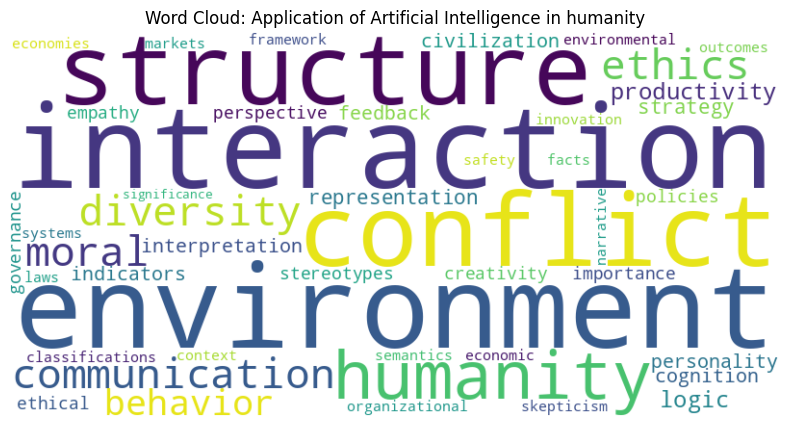


🔷 THEME: APPLICATION OF ARTIFICIAL INTELLIGENCE IN EDUCATION


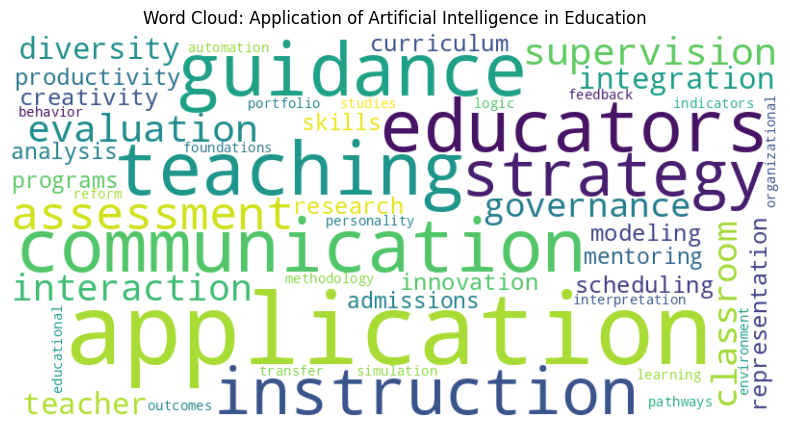


🔷 THEME: APPLICATION OF ARTIFICIAL INTELLIGENCE IN HISTORY


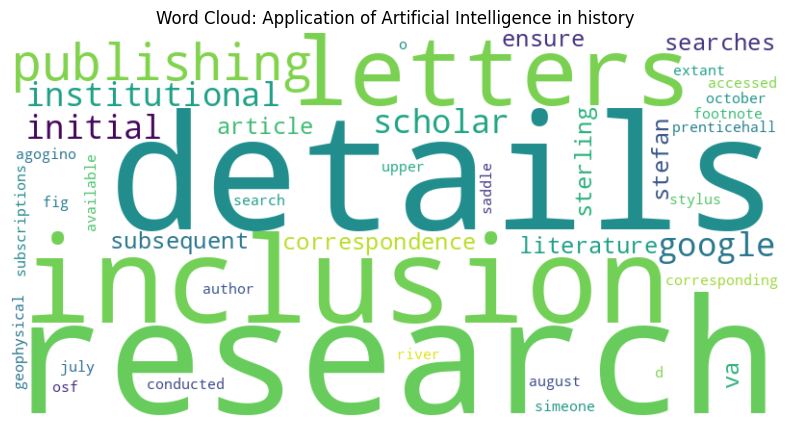


🔷 THEME: APPLICATION OF ARTIFICIAL INTELLIGENCE IN COMPUTER SCIENCE


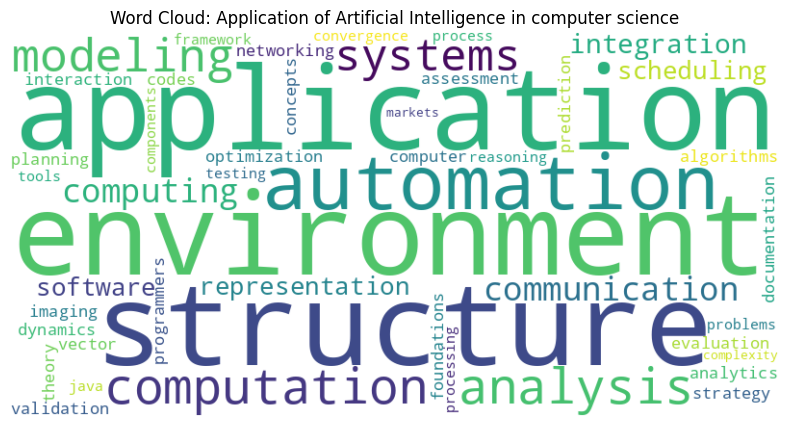


🔷 THEME: APPLICATION OF ARTIFICIAL INTELLIGENCE IN ENGINEERING


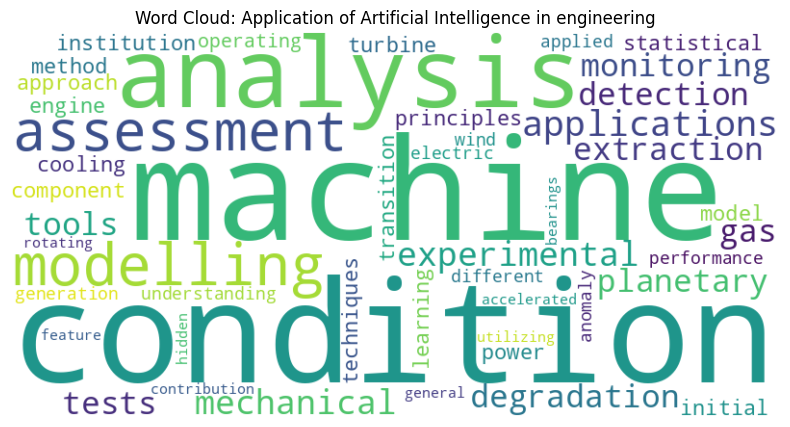

In [5]:
#@title 🤖 Process Text (Thematic Analysis)


# ─── Suppress BERT Setup and Embedding Computation ───
f = io.StringIO()
with contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    model = BertModel.from_pretrained("bert-base-uncased").to(device)

    def compute_embeddings(sentences, batch_size=35):
        embeddings = []
        for i in range(0, len(sentences), batch_size):
            batch = sentences[i:i + batch_size]
            inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt").to(device)
            with torch.no_grad():
                outputs = model(**inputs)
            embeddings.extend(outputs.last_hidden_state[:, 0, :].cpu().numpy())
        return np.array(embeddings)

    sentence_embeddings = compute_embeddings(filtered_sentences, batch_size=35)


# ─── Optional: Dimensionality Reduction ───
# Only apply PCA if needed (e.g., for clustering stability or visualization)
apply_pca = True
if apply_pca:
    pca = PCA(n_components=20)
    X = pca.fit_transform(sentence_embeddings)
else:
    X = sentence_embeddings

# ─── Find Optimal K ───
def find_optimal_k(X, max_k=10):
    inertia_values = []
    cluster_range = range(2, max_k + 1)

    for k in cluster_range:
        km = KMeans(n_clusters=k, random_state=42)
        km.fit(X)
        inertia_values.append(km.inertia_)

    kn = KneeLocator(cluster_range, inertia_values, curve="convex", direction="decreasing")
    optimal_k = kn.knee or 5  # fallback to 5 if knee not found

    #plt.figure(figsize=(8, 5))
    #plt.plot(cluster_range, inertia_values, marker='o', linestyle='--')
    #plt.axvline(optimal_k, color='r', linestyle="--", label=f"Optimal K = {optimal_k}")
    #plt.xlabel("Number of Clusters (K)")
    #plt.ylabel("Inertia")
    #plt.title("Elbow Method for Optimal K")
    #plt.legend()
    #plt.show()

    return optimal_k

# ─── Clustering ───
optimal_k = find_optimal_k(X)

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels = kmeans.fit_predict(X)

# ─── Evaluation ───
sil_score = silhouette_score(X, labels)
print(f"🔹 Silhouette Score: {sil_score:.2f}")

# ─── Cluster Assignment ───
clustered_sentences = {i: [] for i in range(kmeans.n_clusters)}
for label, sentence in zip(labels, filtered_sentences):
    clustered_sentences[label].append(sentence)

# ─── Display Clusters ───
#for cluster, sentences in clustered_sentences.items():
    #print(f"\n🔹 Cluster {cluster}: {len(sentences)} sentences")
    #print("\n".join(sentences[:5]))  # Show first 5 sentences per cluster







theme_sentences = defaultdict(list)

for cluster, sentences in clustered_sentences.items():
    theme_sentences[f"Theme_{cluster}"] = sentences

# Display clusters as themes
#for theme, sentences in theme_sentences.items():
    #print(f"\n🔹 {theme}: {len(sentences)} sentences")

stopwords = get_custom_stopwords()
themes = parse_themes()
theme_sentences = defaultdict(list)
theme_sentiment = {}

theme_top_words = {}

for theme, sents in theme_sentences.items():
    words = " ".join(sents).lower().split()
    common_words = Counter(words).most_common(10)
    theme_top_words[theme] = [word for word, _ in common_words]

# Display top words per theme
# print(theme_top_words)

# Load spaCy model for Named Entity Recognition
nlp = spacy.load("en_core_web_sm")

# Function to get BERT embeddings for words
def get_bert_embedding(word):
    inputs = tokenizer(word, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()



# Prepare embeddings for theme keywords using BERT
theme_embeddings = {
    theme: np.mean([get_bert_embedding(word) for word in keywords], axis=0)
    for theme, keywords in themes.items()
}

# Assign sentences to themes based on embedding similarity
for sentence, emb in zip(filtered_sentences, sentence_embeddings):
    similarities = {
        theme: cosine_similarity([emb], [theme_emb])[0][0]
        for theme, theme_emb in theme_embeddings.items()
    }
    best_theme = max(similarities, key=similarities.get)
    if similarities[best_theme] > 0.5:  # You can tune this threshold
        theme_sentences[best_theme].append(sentence)




# Extract top words per theme using BERT similarity
theme_top_words = defaultdict(list)
for theme, sents in theme_sentences.items():
    words = list(set(
        w.strip(string.punctuation)
        for w in " ".join(sents).lower().split()
        if w.strip(string.punctuation) not in stopwords and w.strip(string.punctuation)
    ))

    word_embeddings = {word: get_bert_embedding(word) for word in words}

    # Compute cosine similarity to theme embedding
    similarities = {
        word: cosine_similarity([emb], [theme_embeddings[theme]])[0][0]
        for word, emb in word_embeddings.items()
    }

    # Select top 10 words with highest similarity
    sorted_words = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:50]
    theme_top_words[theme] = [word for word, _ in sorted_words]

# Initialize Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# Sentiment summary
for theme, sents in theme_sentences.items():
    if sents:
        scores = [sid.polarity_scores(s)['compound'] for s in sents]
        theme_sentiment[theme] = np.mean(scores)
    else:
        theme_sentiment[theme] = None


# Display results
for theme, words in theme_top_words.items():
    print(f"\n🔹 Theme: {theme.upper()}")
    print("Top Words:", ", ".join(words))


for theme, sents in theme_sentences.items():
    print(f"\n🔷 THEME: {theme.upper()}")

    if not sents:
        print("No relevant sentences found.")
        continue

    # ✅ Move this inside the loop so each theme gets its own words
    filtered_words = theme_top_words[theme]

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=50
    )
    wordcloud.generate(" ".join(filtered_words))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud: {theme}")
    plt.show()

In [6]:
#@title 🤖 Process Text (Sentiment Analysis)

# Ensure full sentence visibility
pd.set_option('display.max_colwidth', None)

for theme, sents in theme_sentences.items():
    print(f"\n🔷 THEME: {theme.upper()}")

    if not sents:
        print("No relevant sentences found.")
        continue

    # Sentiment scores
    sentiments = [sid.polarity_scores(s)['compound'] for s in sents]

    # Create DataFrame
    df = pd.DataFrame({'Sentence': sents, 'Sentiment Score': sentiments})

    # Sort for top positive & negative
    df_sorted = df.sort_values(by='Sentiment Score', ascending=False)
    top_positive = df_sorted.head(10)
    top_negative = df_sorted.tail(10)

    print("\n✅ **Top 10 Positive Sentences:**")
    display(top_positive)

    print("\n❌ **Least 10 Negative Sentences:**")
    display(top_negative)

    avg_sent = np.mean(sentiments)
    print(f"\n\033[1m🔸 Average Sentiment Score: {avg_sent:.2f}\033[0m\n")


🔷 THEME: APPLICATION OF ARTIFICIAL INTELLIGENCE IN HUMANITY

✅ **Top 10 Positive Sentences:**


,Sentence,Sentiment Score
476,"by embracing these opportunities and adopting a humancentric approach, we can design a future in which ai serves as a powerful tool for positive change while respecting the values and principles that characterize our shared humanity.",0.9460
1157,"therefore, generative ai in educational applications needs to consider how to protect personal privacy and security, such as using secure data storage and transmission methods, strengthening data access control and permission management measures, to ensure the security and confidentiality of student data.",0.9274
141,but these benefit of the automation and calculation speed of ai tools and gain time and mental resources to focus on creative development tasks.,0.9253
1152,"moreover, the intelligent tutoring system can interact with students parents and teachers, allowing them to better understand students learning situations and performances and provide more comprehensive and effective educational support zhai et al., 2021 .",0.9225
818,"intermediary technologies like natural language processing of spoken dialogue, a key part of having a naturalistic interface with robotic or other smart technologies, have advanced greatly in recent years and with the advent of new approaches to machine learning like deep learning these will undoubtedly continue to improve.",0.9201
1153,"through this personalized tutoring approach, yixue educations intelligent tutoring system can improve students learning efficiency and effectiveness, providing them with a better learning experience and support ouyang and jiao, 2021 .",0.9186
872,but i think this ai is quite amazing and has excellent potential.,0.9134
637,ai is an area of computer science that deals with giving machines the ability to look like they have natural brilliance.,0.9118
522,"artificial intelligence ai is transforming many hrm functions and practices throughout organizations creating system and process efficiencies, performing advanced data analysis, and contributing to the value creation process of the organization.",0.9081
120,"software developers have to keep innovating, improving and learning to use ai effectively in their daily practice participant 2 and as participant 3 asserts certainly will have to be smarter in future in order to use novel ai technologies to their potentials.",0.9081



❌ **Least 10 Negative Sentences:**


,Sentence,Sentiment Score
1049,"this can lead to unequal and unfair outcomes for students, particularly if the bias is related to factors such as race, gender, or socioeconomic status zhai, 2022 , p. 7. openai 2023b acknowledge in their advice to educators that chatgpt may produce content that perpetuates harmful biases and stereotypes, sometimes in subtle ways the model is generally skewed towards content that reflects western perspectives and people para.",-0.7322
267,"307 also regarded states partition as a classification problem, but added more rules of engineering experience, such as rapid or slow degradation patterns, and a 35 principle.",-0.7543
440,"this lack of transparency raises worries about possible biases, errors, or discriminatory effects from ai judgments.",-0.7579
242,"from the deterioration of equipment performance to the complete failure of equipment, it usually goes through a series of different performance degradation stages.",-0.7717
840,"instead, they continue using the same materials and teaching methodologies, rejecting the application of anything that might bring negative outcomes tallvid, 2016 .",-0.7717
221,3.2.3 fault diagnosis under variable working condition fault diagnosis under variable working conditions is still a challenge due to the domain discrepancy problem.,-0.7783
68,"ai at the stage of problem analysis at the stage of problem analysis in the software development life cycle, the problem set is defined in terms of software tools and development requirements by the software development team 41 , 47 , 48 .",-0.7964
209,"to quickly detect early failure and avoid the fault extension, the sensibility of methods for early failure is of the utmost importance.",-0.8402
206,low recall would lead to the omission of fault and cause catastrophic damages.,-0.8720
1088,"it was also reported that kenyan workers were paid about 2 per hour to work as content moderators for systems associated with the creation of chatgpt, sifting through disturbing content like sexual abuse, hate speech, and violence perrigo, 2023 .",-0.9136



🔸 Average Sentiment Score: 0.20


🔷 THEME: APPLICATION OF ARTIFICIAL INTELLIGENCE IN EDUCATION

✅ **Top 10 Positive Sentences:**


,Sentence,Sentiment Score
1020,"in this regard, this study brings great significance to the field in revealing stem teachers overall positive perception regarding this innovative aibased scaffolding and opportunities for future improvements.",0.9522
1285,"additionally, creating a positive and encouraging classroom environment can help to motivate the student to improve their performance in science.",0.9468
1300,"finalise the unit with a class debate about which energy source is the best for the community this teaching unit allows students to actively engage in the learning process, explore and research the subject, explain their findings, elaborate a plan, evaluate their understanding and participation and debate about the best energy source for the community.",0.9460
960,"results artificial intelligence role as a source for superior scaffolding most teachers responded positively to the use of the aiss for learning in that the system was able to act as an expert model, providing qualified examples of scientific writing, valuable resources to make users claims stronger, and immediate individualized feedback.",0.9429
759,"similar content being viewed by others employing adaptive learning and intelligent tutoring robots for virtual classrooms and smart campuses: reforming education in the age of artificial intelligence chapter 2022 from robots to books: an introduction to smart applications of ai in education aied chapter 2024 smart citizens and ai: trusting the ai chapter 2025 explore related subjects discover the latest articles and news from researchers in related subjects, suggested using machine learning.",0.9423
1412,"through this intelligent speech interaction method, vipkids intelligent speech teaching system can improve students oral expression ability and learning effectiveness, providing better learning experience and support for students castelli and manzoni, 2022 .",0.9413
1395,"through this intelligent homework grading method, turnitin platform can improve the efficiency and accuracy of homework grading while ensuring fairness and objectivity, providing students with a better learning experience and support.",0.9337
781,if educational cobots had aied capabilities they could do things like monitor learners as they engage with intelligent learning environments the iles could liaise directly with the cobot; flag and attend to learners who need extra help that the ile cannot provide; keep learners engaged and interested; and answer questions that a learner might have.,0.9325
1371,"the continuous development and improvement of these technologies will provide more powerful and intelligent support for the application of generative ai in education, art, entertainment, and other fields.",0.9307
1384,"in addition, the intelligent teaching system can also interact with students parents and teachers, allowing parents and teachers to better understand students learning situations and performances, and provide more comprehensive and effective educational support.",0.9225



❌ **Least 10 Negative Sentences:**


,Sentence,Sentiment Score
319,realtime broken rotor bar fault detection and classification by shallow 1d convolutional neural networks.,-0.7003
434,a deep learning driven method for fault classication and degradation assessment in mechanical equipment.,-0.7269
523,"by continuously processing realtime data, aiequipped selfdriving cars can detect and respond to obstacles, traffic signals, and pedestrian movements, significantly reducing the likelihood of accidents caused by human errors.",-0.7430
1341,"research in science education, 48 4, 865885. https:doi.org10.1007s1116501695902 article google scholar karim, r. 2023. chatgpt: old ai problems in a new guise, new problems in disguise .",-0.7506
1416,"additionally, if a student makes a grammar mistake, the program may provide incorrect correction suggestions, but the student may not understand why the suggestion is correct and how to avoid similar mistakes.",-0.7750
200,gathgeva fuzzy clustering was used to divide the degradation stage and further to evaluate the degradation degree of bearing performance.,-0.7783
239,exploiting the generative adversarial framework for oneclass multidimensional fault detection.,-0.7964
1432,"for example, if a student comes from a poor family, they may not have the opportunity to use highquality learning tools and resources, which may lead to their learning achievements being inferior to those of other students.",-0.7982
530,"by continuously learning from new data, these ai systems can react to evolving fraud tendencies and increase the resilience of financial institutions against fraudulent threats.",-0.8176
411,rolling bearing early weak fault detection and performance degradation assessment based on vmd and svdd.,-0.8402



🔸 Average Sentiment Score: 0.21


🔷 THEME: APPLICATION OF ARTIFICIAL INTELLIGENCE IN HISTORY

✅ **Top 10 Positive Sentences:**


,Sentence,Sentiment Score
9,"the initial search was conducted on 13 october 2022, with subsequent searches conducted until 18 july 2023 to ensure the inclusion of extant literature see osf for search details footnote 14 .",0.3818
0,institutional subscriptions fig.,0.0000
1,geophysical research letters .,0.0000
2,"article google scholar simeone, o.",0.0000
3,"available: https:ti.arc.nasa.govc6 accessed on august 1 2020. a agogino, k goebel.",0.0000
4,institutional subscriptions fig.,0.0000
5,upper saddle river: prenticehall.,0.0000
6,corresponding author correspondence to stefan a. d. popenici .,0.0000
7,"sterling, va: stylus publishing.",0.0000
8,"sterling, va: stylus publishing.",0.0000



❌ **Least 10 Negative Sentences:**


,Sentence,Sentiment Score
9,"the initial search was conducted on 13 october 2022, with subsequent searches conducted until 18 july 2023 to ensure the inclusion of extant literature see osf for search details footnote 14 .",0.3818
0,institutional subscriptions fig.,0.0000
1,geophysical research letters .,0.0000
2,"article google scholar simeone, o.",0.0000
3,"available: https:ti.arc.nasa.govc6 accessed on august 1 2020. a agogino, k goebel.",0.0000
4,institutional subscriptions fig.,0.0000
5,upper saddle river: prenticehall.,0.0000
6,corresponding author correspondence to stefan a. d. popenici .,0.0000
7,"sterling, va: stylus publishing.",0.0000
8,"sterling, va: stylus publishing.",0.0000



🔸 Average Sentiment Score: 0.04


🔷 THEME: APPLICATION OF ARTIFICIAL INTELLIGENCE IN COMPUTER SCIENCE

✅ **Top 10 Positive Sentences:**


,Sentence,Sentiment Score
40,intelligent biological and ideally intelligent artificial systems e.g.,0.8316
62,"the programming language swift uses iterative optimization processes which are mathematically implemented by analyzing and optimizing the incremental change of an existing function, to the desired result.",0.8176
431,"the core concept of duolingo is to turn language learning into a game, helping users to learn new languages easily and happily through interactive learning methods lim et al., 2022 .",0.8020
44,"applying these technologies artificial intelligence manages complex tasks like natural language processing 22 , i.e.",0.7964
379,"as the field matured through the 1990s and into the 2000s, research began to diversify and deepen, exploring varied facets of aied such as intelligent tutoring systems woolf, 2010 , adaptive learning environments desmarais baker, 2012 as well as supporting collaborative learning environments dillenbourg jermann, 2007 .",0.7906
47,"conventional scheduling models face the challenge of a very broad search space, comprising multiple input factors and scenarios and usually have to make simplifying assumptions to deliver reproducible results 52 : ai algorithms based on nonlinear and selfoptimizing algorithms, like ant colony optimization can solve such problems successfully by iteratively reducing decision complexity 53 .",0.7717
370,"moreover, the learning experience supported by expert modeling can activate a learners declarative and procedural memory modules, which in turn can improve their ability to apply their existing knowledge to perform given tasks anderson et al., 1997 ; papathomas, 2016 .",0.7579
242,251 proposed an improved unsupervised deep trust network model named median filtering dbn.,0.7506
179,"1 robust feature extraction based methods ae has strong ability for feature extraction, recently, researchers have developed many ae variants, such as deep autoencoder dae, sdae, and contractive autoencoder cae, to automatically extract highlevel representative features from data collected under the noisy environment.",0.7430
415,"the encoder is responsible for encoding input data into latent variables, while the decoder is responsible for decoding latent variables into output data kingma and welling, 2019 .",0.7351



❌ **Least 10 Negative Sentences:**


,Sentence,Sentiment Score
300,a nonparametric fault isolation approach through oneclass classification algorithms.,-0.6597
157,"154 proposed a dual discriminator conditional gan to learn data distributions from signals on multimodal fault samples, and automatically synthesized realistic 1d signals of each fault.",-0.6597
196,"3.3 open source datasets and codes 3.3.1 open source datasets in the field of aienabled fault diagnosis, it is quite difficult to obtain highquality datasets from real industrial scenarios and it also lacks open source codes.",-0.6697
77,"ai identifies and simulates attack patterns to discover security gaps, defects and errors in a targeted way 69 .",-0.7003
273,"5 uncertainty modeling if the cost and risk of decision need to be considered, it is necessary to estimate the uncertainty of the rul estimation.",-0.7096
265,"256 discussed the relationship between shortterm failure prediction and longterm rul estimation, arguing that a joint model could prevent inconsistent results.",-0.7351
178,"3.2.4 fault diagnosis for low signaltonoise ratio signals in real industrial scenario, the fault patterns are often overwhelmed by heavy background noise.",-0.7430
281,"4.5.2 prognosis in realworld scenarios there are many limitations and uncertainties in the real open world, such as restricted computing resources, variable working conditions, unknown failure modes, etc.",-0.8074
229,"239 proposed a method for evaluating the performance degradation of ball bearings based on curve component analysis and selforganizing mapping som network, which was more sensitive to weak degradation.",-0.8739
214,"225 proposed the negative log likelihood probability based on the twodimensional hmm as the bearing performance degradation index, showing the sensitivity to weak defects.",-0.9136



🔸 Average Sentiment Score: 0.06


🔷 THEME: APPLICATION OF ARTIFICIAL INTELLIGENCE IN ENGINEERING

✅ **Top 10 Positive Sentences:**


,Sentence,Sentiment Score
1,"25 , selforganizing map and knn were used for cooling fan bearing monitoring.",0.3182
0,"in statistical modelling and machine learning principles for bioinformatics techniques, tools, and applications pp.",0.0000
3,47 after feature extraction with sae for gas turbine engine gas path anomaly detection.,0.0000
4,48 for power generation monitoring.,0.0000
5,49 to detect the change point of gearboxes based on the graph model.,0.0000
7,condition monitoring techniques of ball bearings in nonstationary conditions.,0.0000
8,condition monitoring of wind turbine planetary gearboxes under different operating conditions.,0.0000
9,a general anomaly detection approach applied to rolling element bearings via reduceddimensionality transition matrix analysis.,0.0000
13,proceedings of the institution of mechanical engineers.,0.0000
15,electric power syst res.,0.0000



❌ **Least 10 Negative Sentences:**


,Sentence,Sentiment Score
8,condition monitoring of wind turbine planetary gearboxes under different operating conditions.,0.0000
9,a general anomaly detection approach applied to rolling element bearings via reduceddimensionality transition matrix analysis.,0.0000
13,proceedings of the institution of mechanical engineers.,0.0000
15,electric power syst res.,0.0000
2,41 for wind turbine fault detection.,-0.4019
6,52 for bearings initial fault detection.,-0.4019
10,dcnn for condition monitoring and fault detection in rotating machines and its contribution to the understanding of machine nature.,-0.4019
11,a method for performance degradation assessment of wind turbine bearings based on hidden markov model and fuzzy cmeans model.,-0.5267
12,degradation assessment of ball bearings utilizing curvilinear component analysis.,-0.5267
14,an experimental platform for bearings accelerated degradation tests.,-0.5267



🔸 Average Sentiment Score: -0.15



🔹 Optimal K selected: 5
🔹 Silhouette Score: 0.13
📊 Calinski-Harabasz Score: 402.05


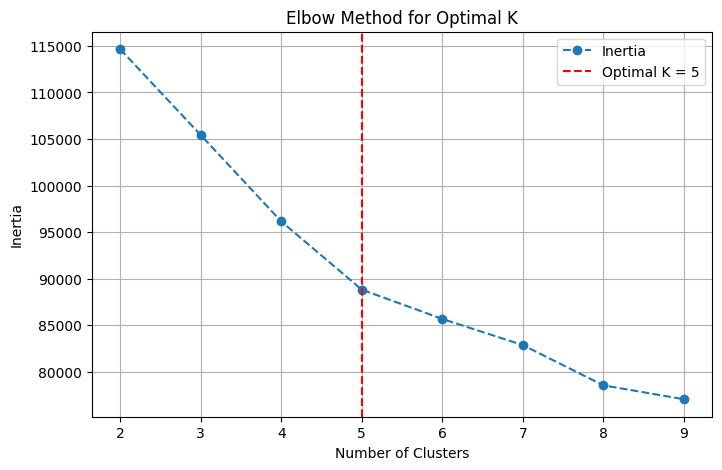

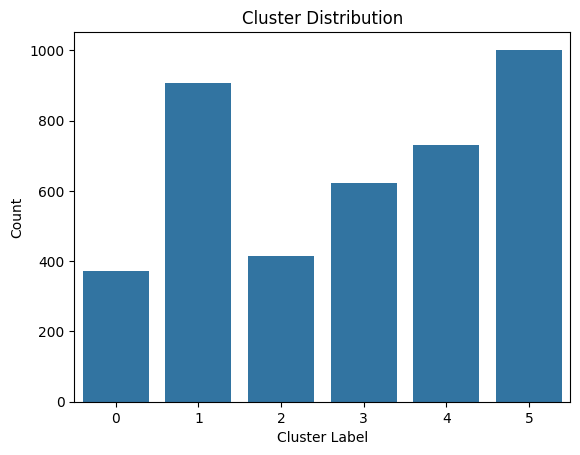

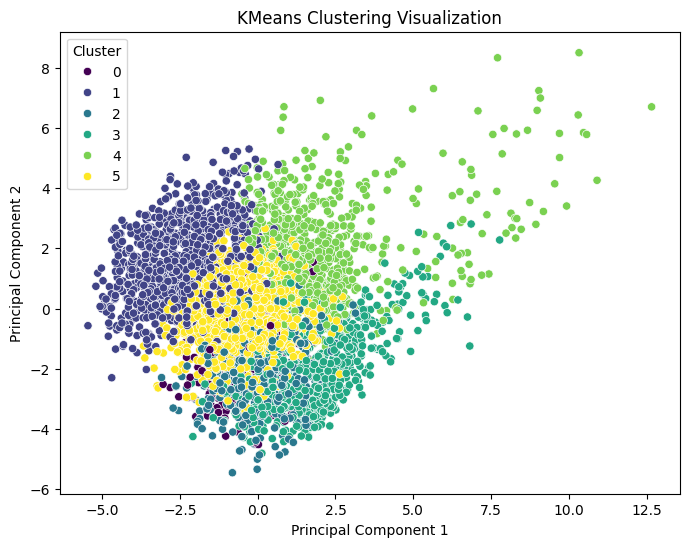

🧠 Theme Coherence (Application of Artificial Intelligence in humanity): 0.80
🧠 Theme Coherence (Application of Artificial Intelligence in Education): 0.80
🧠 Theme Coherence (Application of Artificial Intelligence in history): 0.77
🧠 Theme Coherence (Application of Artificial Intelligence in computer science): 0.79
🧠 Theme Coherence (Application of Artificial Intelligence in engineering): 0.80


In [7]:
#@title Validation and Reliability Check

print(f"\033[1m🔹 Optimal K selected: {optimal_k}\033[0m")

kmeans = KMeans(n_clusters=6, random_state=42)
labels = kmeans.fit_predict(X)


# 1️⃣ **Silhouette Score**
sil_score = silhouette_score(X, labels)
print(f"\033[1m🔹 Silhouette Score: {sil_score:.2f}\033[0m")

# Calinski-Harabasz Index
ch_score = calinski_harabasz_score(X, labels)
print(f"\033[1m📊 Calinski-Harabasz Score: {ch_score:.2f}\033[0m")


# 2️⃣ **Elbow Method**
inertia_values = []
cluster_range = range(2, 10)

for k in cluster_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    inertia_values.append(km.inertia_)

# Plot the elbow curve with the optimal K marked
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia_values, marker='o', linestyle='--', label='Inertia')
plt.axvline(optimal_k, color='red', linestyle='--', label=f'Optimal K = {optimal_k}')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.legend()
plt.grid(True)
plt.show()

# 3️⃣ **Cluster Distribution**
sns.countplot(x=labels)
plt.xlabel("Cluster Label")
plt.ylabel("Count")
plt.title("Cluster Distribution")
plt.show()

# 4️⃣ **2D Visualization using PCA**
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette="viridis")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("KMeans Clustering Visualization")
plt.legend(title="Cluster")
plt.show()




#Theme Coherence

def average_intra_theme_similarity(sentences, embeddings):
    if len(sentences) < 2:
        return None
    indices = [i for i, s in enumerate(filtered_sentences) if s in sentences]
    vectors = [sentence_embeddings[i] for i in indices]
    pairs = list(combinations(vectors, 2))
    sims = [cosine_similarity([a], [b])[0][0] for a, b in pairs]
    return np.mean(sims)

for theme, sents in theme_sentences.items():
    score = average_intra_theme_similarity(sents, sentence_embeddings)
    if score is not None:
        print(f"\033[1m🧠 Theme Coherence ({theme}): {score:.2f}\033[0m")